In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 5.1) Initialization

In [2]:
def readData(filename):
    print("Reading %s" % filename)
    ds = pd.read_csv(filename, header=None, dtype=float)
    return ds
s1 = readData('sounds/sound1.dat')

Reading sounds/sound1.dat


In [3]:
s2 = readData('sounds/sound2.dat')

Reading sounds/sound2.dat


In [4]:
S = np.hstack((s1,s2))

In [5]:
def createRandomMatrix(dim=2, salt = 0.01):
    A = np.random.random_sample(dim**2).reshape((dim,dim))
    A = A + salt*np.diag((dim,dim)) # make sure that A is always invertable 
    A_inv = np.linalg.inv(A)
    return A,A_inv
A, A_inv = createRandomMatrix(2)
A.shape

(2, 2)

In [26]:
X = np.dot(A,S.T) # 2*18000
X[:,:5]

array([[ 0.        , -0.00010923, -0.00270009, -0.00258854,  0.00081251],
       [ 0.        , -0.00011332, -0.00279669, -0.00257377,  0.00079781]])

In [27]:
total_cols = X.shape[1]
permuted_cols = np.random.permutation(total_cols)
print(permuted_cols)

[15201    15 17000 ...,  1299  1740 17528]


In [28]:
X_permuted = X[:, permuted_cols]
X_permuted[:,:5]

array([[ -3.20376440e+00,  -2.80802388e-04,  -1.79577748e-01,
          1.57034085e+00,  -1.16976389e-02],
       [ -2.97909207e+00,  -6.63638224e-04,  -1.51501430e-01,
          1.47489752e+00,  -2.13410197e-02]])

In [469]:
def computeCorrelation(x,s, label="X"):
    x_size = x.shape[0]
    data = np.vstack((x,s))
    corrs = np.corrcoef(data)
    corrs_trimmed = corrs[:x_size, x_size:,]

#     for i in range(x_size):
#         for j in range(x_size):
#             print("corr(%s%d,s%d) = %.8f" % (label, i,j, corrs_trimmed[i,j] ))
    return corrs_trimmed

computeCorrelation(X_permuted,S.T)


array([[ 0.01134748, -0.014357  ],
       [ 0.01188087, -0.01477455]])

In [50]:
X_permuted[:,:5]

array([[ -3.20376440e+00,  -2.80802388e-04,  -1.79577748e-01,
          1.57034085e+00,  -1.16976389e-02],
       [ -2.97909207e+00,  -6.63638224e-04,  -1.51501430e-01,
          1.47489752e+00,  -2.13410197e-02]])

In [44]:
np.mean(X, axis=1).reshape((2,1))

array([[ 0.00990363],
       [ 0.01012883]])

In [138]:
X_centered = X - np.mean(X, axis=1).reshape((2,1))

In [137]:
X_permuted_centered = X_permuted - np.mean(X_permuted, axis=1).reshape((2,1))

In [36]:
dim = 2
W_init,_ = createRandomMatrix(2)

# 5.2 Optimization

In [497]:
from scipy.io.wavfile import write
write('test0.wav', 8192, S[:,0]) # bird sound
write('test1.wav', 8192, S[:,1]) # hallelujah 

write('x_centered0.wav', 8192, X_centered[0,:])
write('x_centered1.wav', 8192, X_centered[1,:])

write('x_permuted_centered0.wav', 8192, X_permuted_centered[0,:])
write('x_permuted_centered1.wav', 8192, X_permuted_centered[1,:])

In [501]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))
def firstDerSigmoid(x):
    return sigmoid(x)*( 1 - sigmoid(x))
def secondDerSigmoid(x):
    return firstDerSigmoid(x) - 2*firstDerSigmoid(x)*sigmoid(x)
sigmoid(1)
firstDerSigmoid(1)
secondDerSigmoid(1)

-0.090857747672948408

[-10.     -9.999  -9.998 ...,   9.998   9.999  10.   ]


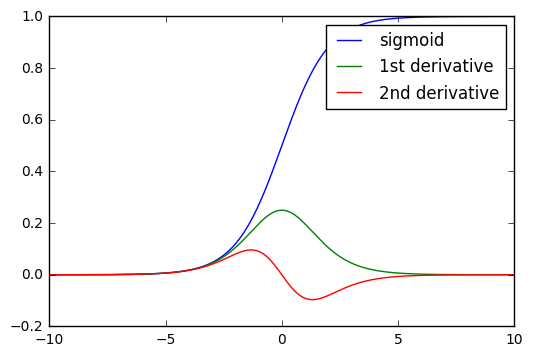

In [502]:
x_lin = np.arange(-10,10.0001,0.001)
print(x_lin)
plt.plot( x_lin, sigmoid(x_lin), label='sigmoid' )
plt.plot( x_lin, firstDerSigmoid(x_lin), label='1st derivative')
plt.plot( x_lin, secondDerSigmoid(x_lin), label='2nd derivative')
plt.legend()

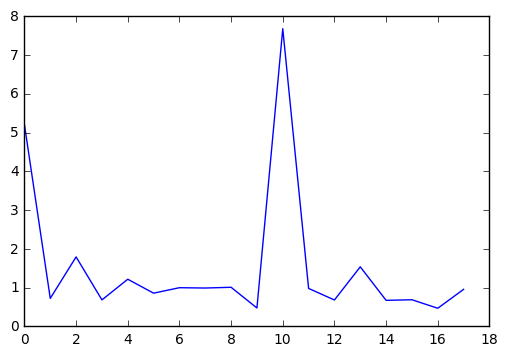

In [504]:
def computeLoss(x,w):
    second_term = np.sum(np.log(firstDerSigmoid(np.dot(w,x))),axis=0)  
    loss = np.log(np.linalg.det(w)) + np.mean(second_term)
    return loss

def computeIndividualLoss(x,w):
    return np.log(np.linalg.det(w)) + np.sum( np.log( firstDerSigmoid(np.dot(w,x)) ) )

def regularGradientLearning(x, w_init, original_data, eta=0.1, epoch=1):
    w = np.copy(w_init)
    
    loss = computeLoss(x,w)
#     print("Epoch %d - loss %.5f" % (0, loss))
    norm = []
    for e in range(epoch):

        for i in range(x.shape[1]):
            eta_t = eta / (i+1)
    
            w_inv = np.linalg.inv(w)
        
            w_dot_x = np.dot(w, x[:,i])
            sigs = 1 - 2*sigmoid(w_dot_x)
 
            outer_prod = np.outer(sigs, x[:,i])
            grad = w_inv.T + outer_prod
            w = w + eta_t*grad

            if i % 1000 == 0:
                norm.append(np.linalg.norm(grad))

        loss = computeLoss(x,w)
#         print("Epoch %d - loss %.5f" % (e+1, loss))
    return w, norm

W_hiro = np.array([[ 0.9297626,0.28035085],[ 0.2388984, 0.28682381]])
w_learnt, norm_reg = regularGradientLearning(X_centered, W_hiro, S.T, epoch=1, eta=0.5)
s_est = np.dot(w_learnt,X_centered) 
computeCorrelation(s_est,S.T, label="S_estimate")
plt.plot(norm_reg)

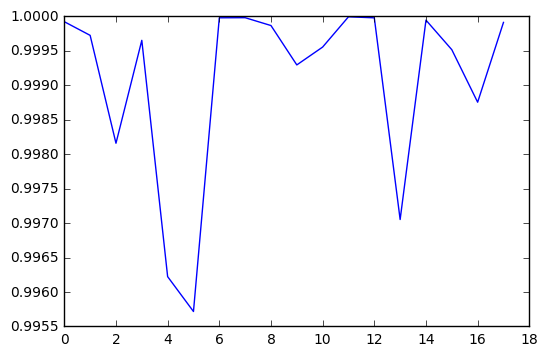

In [515]:
def naturalGradientLearning(x, w_init, original_data, eta=0.1, epoch=1):
    w = np.copy(w_init) / np.linalg.norm(w_init)
    p = x.shape[1]
    norm = []
    for i in range(p):
        w_dot_x = np.dot(w, x[:,i])
        sigs = 1 - 2*sigmoid(w_dot_x)
        dirac = np.eye(2)
        outer_pd = np.outer(sigs, w_dot_x)
        grad = ( np.dot(dirac, w) + np.dot(outer_pd, w))
        if i % 1000 == 0:
            norm.append( np.linalg.norm(grad) )
        w = ( w + grad*eta )
        w = w / np.linalg.norm(w) # without this the algorithm doesn't seem to work
    return w, norm
w_nat, nat_norms = naturalGradientLearning(X_centered, W_hiro, S.T, epoch=1, eta=0.1)
plt.plot(nat_norms)

In [468]:
s_x_est_w_init = np.dot(W_hiro,X_centered) 
computeCorrelation(s_x_est_w_init,S.T, label="X")

corr(X0,s0) = 0.81550475
corr(X0,s1) = 0.57977778
corr(X1,s0) = 0.80482207
corr(X1,s1) = 0.59453009


array([[ 0.81550475,  0.57977778],
       [ 0.80482207,  0.59453009]])

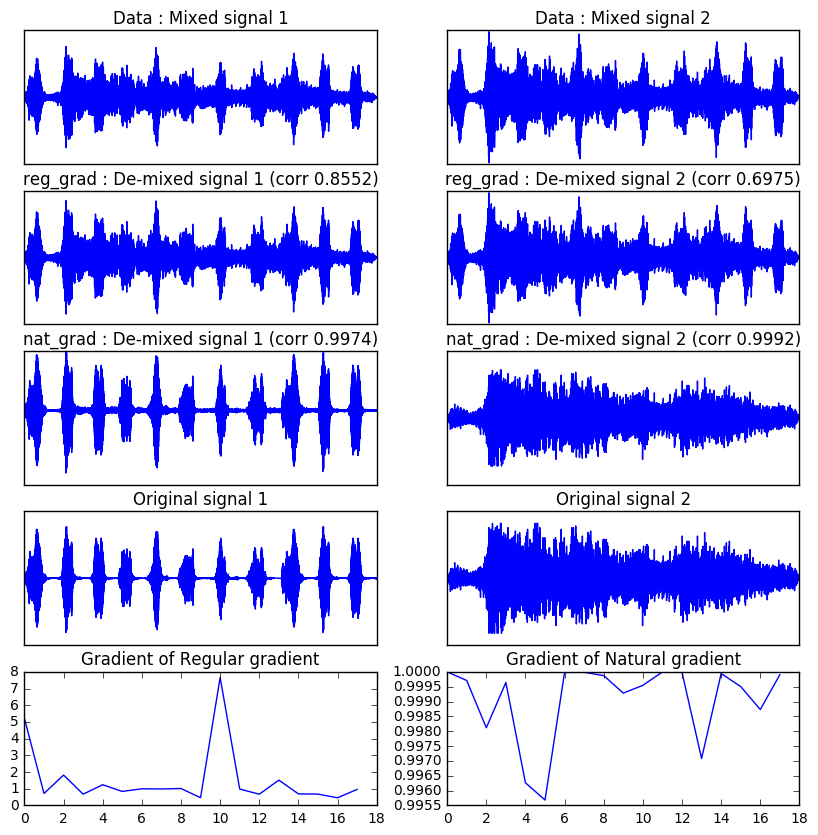

In [518]:
def plotExperiment(x, w_init, original_s,  dataset):
    total = x.shape[1]
    x_range = np.array(range(total))
    
    plt.figure(figsize=(10,10))
    
    for i in range(x.shape[0]):
        plt.subplot(5,2,i+1)
        plt.plot(x_range, x[i,:].T)
        plt.title('%s : Mixed signal %d' % (dataset, i+1) )
        plt.xticks([])
        plt.yticks([])
        
    w_reg, norm_reg = regularGradientLearning(x, w_init, original_s, epoch=1, eta=0.5)
    s_est_reg = np.dot(w_reg,x) 
    corr = computeCorrelation(    s_est_reg, original_s)
    learning_algo = 'reg_grad'
    for i in range(x.shape[0]):
        plt.subplot(5,2,2 + i+1)
        plt.plot(x_range, s_est_reg[i,:].T)
        plt.title('%s : %s %d (corr %.4f)' % (learning_algo, 'De-mixed signal', i+1, corr[i,i]) )
        plt.xticks([])
        plt.yticks([])


    w_nat, norm_nat = naturalGradientLearning(x, w_init, original_s, epoch=1, eta=0.1)
    s_est = np.dot(w_nat,x) 
    corr = computeCorrelation(s_est, original_s)
    learning_algo = 'nat_grad'
    for i in range(x.shape[0]):
        plt.subplot(5,2,4+ i+1)
        plt.plot(x_range, s_est[i,:].T)
        plt.title('%s : %s %d (corr %.4f)' % (learning_algo, 'De-mixed signal', i+1, corr[i,i]) )
        plt.xticks([])
        plt.yticks([])
        
    for i in range(x.shape[0]):
        plt.subplot(5,2,6+ i+1)
        plt.plot(x_range, original_s[i,:].T)
        plt.title('%s %d' % ('Original signal', i+1) )
        plt.xticks([])
        plt.yticks([])

    plt.subplot(5,2,9)
    plt.plot(norm_reg)
    plt.title('Gradient of Regular gradient')
    
    
    plt.subplot(5,2,10)
    plt.plot(norm_nat)
    plt.title('Gradient of Natural gradient')
plotExperiment(X, W_hiro, S.T, dataset="Data")    

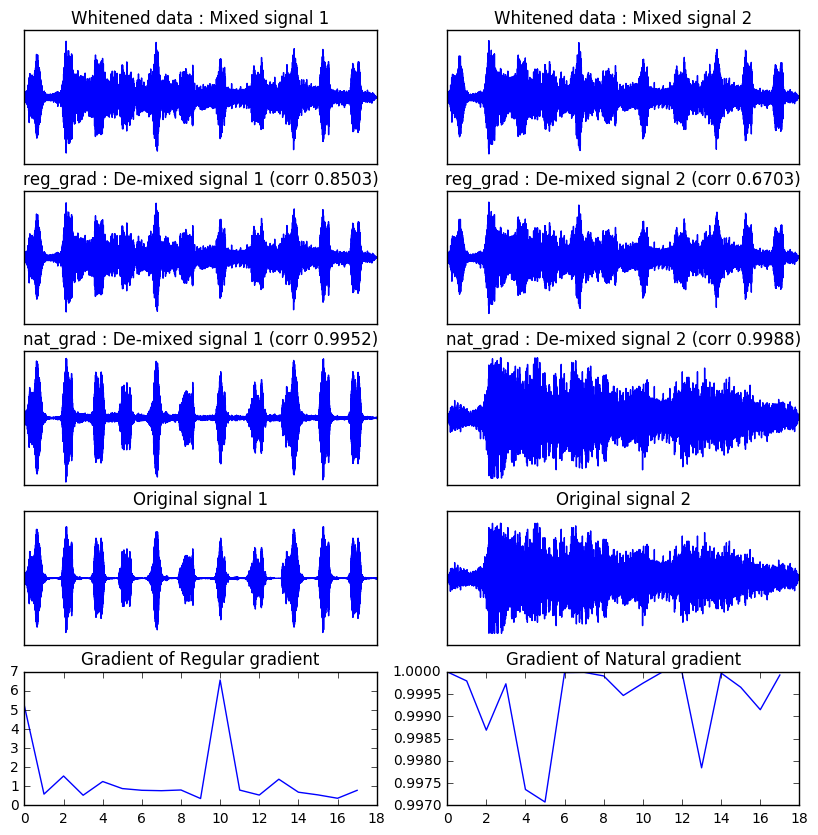

In [519]:
from scipy.cluster.vq import whiten
X_whitenen = whiten(X.T).T
plotExperiment(X_whitenen, W_hiro, S.T, dataset="Whitened data")    

## The differences between regular gradient and natural gradient method